In [1]:
from IPython.display         import SVG
from matplotlib              import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from os                      import makedirs
from os.path                 import exists, isdir

import numpy as np

from sklearn.metrics         import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import binarize

from keras                   import backend as K
from keras.callbacks         import EarlyStopping, ProgbarLogger
from keras.layers            import (Activation, add, BatchNormalization, Conv1D, Dense,
                                     Dropout, Flatten, Input, Permute, Reshape, ZeroPadding1D)
from keras.models            import load_model, Model
from keras.utils.vis_utils   import model_to_dot

Using TensorFlow backend.


#### First goes MAPS data (for different recording rooms and instruments):
##### Loss may become NaN:
`[:9]     176 - Chromatic scale
[9:273]   1   - One note
[273:339] 15  - Repeat
[339:603] 1   - Stackato
[603:735] 30  - Tremolo`

##### Gradients are always Ok:
`[735:765] inf - Mus
 [765:3736] 1  - Chords`

`[3736:3736+9]   Chromatic scale`
<br>--//-- for 9 MAPS parts except part 8 (__*SptkBGCl*__) which contains just 30 MUS series.

#### Then goes AudioLab-erlangen data.

In [2]:
cqts, notes = map(np.load, ['Cqts {}.npy'.format('Normalized' if exists('Cqts Normalized.npy')
                                                 else 'Float16 512798'), 'Notes 512798.npy'])
print('{} chords'.format(len(notes)))

512798 chords


In [3]:
if not exists('Cqts Normalized.npy'):
    print('cqts before norm\tin range [{:.2e} - {:.3f} - {:.3f}]'.format(cqts.min(), cqts.mean(), cqts.max()))

    nonZeros, frameNorms = np.count_nonzero(cqts), cqts.max(2, keepdims=True)
    assert frameNorms.shape == (len(notes), 5, 1)
    frameNorms[frameNorms == 0] = K.epsilon()
    cqts /= frameNorms
    
    assert cqts.min() == 0 and nonZeros >= np.count_nonzero(cqts)
    cqts[cqts == 0] = K.epsilon()
    assert cqts.min() > 0 and np.count_nonzero(cqts) == cqts.size
    
    # Ideally there should only be one cqt=1 per frame (nBins per chord) after normalization, but there may be slightly more
    numOnesRatio = tuple(map(lambda i: len(cqts) * cqts.shape[1] / len(np.hstack([(c == 1).nonzero()[i] for c in cqts])), [0, 1]))
    assert (min(numOnesRatio) > .998 and max(numOnesRatio) <= 1)

    # Not using batch norm as almost all norm factors are already ones:
    maxBins = cqts.max(0).max(0)
    assert maxBins.shape == (440,) and maxBins[maxBins == 1].sum() / len(maxBins) > .95 and maxBins.min() > .5
    np.save('Cqts Normalized', cqts)

cqtsTrain, cqtsTest, notesTrain, notesTest = train_test_split(cqts, notes, random_state=42)
print('Frame-normalized cqts\tin range [{:.2e} - {:.3f} - {:.3f}]'.format(cqts.min(), cqts.mean(), cqts.max()))

Frame-normalized cqts	in range [5.96e-08 - 0.026 - 1.000]


#### http://c4dm.eecs.qmul.ac.uk/ismir15-amt-tutorial/AMT_tutorial_ISMIR_2015.pdf Page 50, Slide 100, Evaluation Metric 3 [Dixon, 2000]:
$$Acc = \frac{\sum_{n}Ntp[n]}{\sum_{n}Nfp[n] + \sum_{n}Nfn[n] + \sum_{n}Ntp[n]} = \frac{tp}{tp + fp + fn} = \frac{tp}{pp + rp - tp}$$

In [4]:
def Dixon(yTrue, yPred):
    # true (correct) positives, predicted positives = tp + fp, real (ground-truth) positives = tp + fn
    tp, pp, rp = K.sum(yTrue * K.round(yPred)), K.sum(K.round(yPred)), K.sum(yTrue)
    return 1 if pp == 0 and rp == 0 else tp / (pp + rp - tp + K.epsilon())

batchSize, modelFolder = 1_024, 'Models' # HDF5-files

In [3]:
evalBatchSize, model = 16_384, None
hist = np.load(modelFolder + '/Training History.npy')[0] if exists(modelFolder + '/Training History.npy') else None
if not isdir(modelFolder): makedirs(modelFolder)
if exists(modelFolder + '/Training Model.hp5'):
    print('Loading pre-trained model...')
    model = load_model(modelFolder + '/Training Model.hp5', {'Dixon': Dixon})
    print('Spent', len(hist['loss']), 'epochs, current validation loss and Dixon are:')
    print(model.evaluate(cqtsTest, notesTest, evalBatchSize, 1))
else:
    nBins = cqts.shape[2] // notes.shape[1]
    maxFeatures = cqts.shape[1] * 96 * nBins
    def BottleNeck(nFilters, reducedLen, x):
        x =    Permute((2, 1))(Reshape((nFilters, reducedLen))(x))
        return Permute((2, 1))(add([x,
            Dropout(.5)(Conv1D(       nFilters,       1                )(Activation('relu')(BatchNormalization()(
            Dropout(.5)(Conv1D(max(1, nFilters // 4), 3, padding='same')(Activation('relu')(BatchNormalization()(
            Dropout(.5)(Conv1D(max(1, nFilters // 4), 1                )(Activation('relu')(BatchNormalization()(x))))))))))))]))

    inputs = Input(shape=(cqts.shape[1], cqts.shape[2]))
    
    resSum = BottleNeck(cqts.shape[2], cqts.shape[1], Permute((2, 1))(BottleNeck(cqts.shape[1], cqts.shape[2], inputs)))
    octave = 12 * nBins
    resSum = Permute((2, 1))(ZeroPadding1D(-cqts.shape[2] % octave // 2)(resSum))

    resSum = BottleNeck(cqts.shape[1] * 4, octave * 2, BottleNeck(cqts.shape[1] * 2, octave * 4, resSum))
    resSum = BottleNeck(cqts.shape[1] * 16, nBins * 6, BottleNeck(cqts.shape[1] * 8, octave,     resSum))
    resSum = BottleNeck(cqts.shape[1] * 96, nBins,     BottleNeck(cqts.shape[1] * 32, nBins * 3, resSum))
    
    resSum = Flatten()(resSum)
    resSum = add([resSum, Dropout(.5)(Dense(maxFeatures)(Activation('relu')(BatchNormalization()(
                          Dropout(.5)(Dense(maxFeatures)(Activation('relu')(BatchNormalization()(resSum))))))))])
    
    model = Model(inputs, Dense(notes.shape[1], activation='sigmoid')(
                          Dropout(.5)                   (Activation('relu')(BatchNormalization()(resSum)))))
    model.compile('Adam', 'categorical_crossentropy', [Dixon])
SVG(model_to_dot(model, True, False, 'LR').create(format='svg'))

Loading pre-trained model...
Spent 99 epochs, current validation loss and Dixon are:
128200/128200 [==============================] - 56s 436us/step
[2.5348345713682368, 0.6460155806861319]


In [48]:
class ValDixon_ProgbarLogger(ProgbarLogger):
    def __init__(self):
        super().__init__()
        self.verbose = 1 # ignore the argument from fit()

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.params['metrics'].remove('val_loss')

# To print the 1st line with the number of train/validate samples, and to init history dict:
newHist = model.fit(cqtsTrain, notesTrain, batchSize, 0 if hist else 1, validation_data=(cqtsTest, notesTest)).history
if not hist: hist = newHist
loss, dixonTrain, dixonVal = float('inf'), hist['Dixon'][-1], hist['val_Dixon'][-1]
while loss > hist['loss'][-1]:
    loss, newHist = hist['loss'][-1], model.fit(cqtsTrain, notesTrain, batchSize, 1, 0, callbacks=[
        ValDixon_ProgbarLogger()], validation_data=(cqtsTest, notesTest)).history
    hist = {key: hist[key] + val for key, val in newHist.items()}
    if dixonTrain < hist['Dixon'][-1] and dixonVal < hist['val_Dixon'][-1]:
        dixonTrain, dixonVal = hist['Dixon'][-1], hist['val_Dixon'][-1]
        np.save('{}/Training History {:.2f} {:.2f}'.format(
            modelFolder, hist['Dixon'][-1] * 100, hist['val_Dixon'][-1] * 100), [hist])
        model.save('{}/Training Model {:.2f} {:.2f}.hp5'.format(
            modelFolder, hist['Dixon'][-1] * 100, hist['val_Dixon'][-1] * 100))

Epoch 1/100
384598/384598 [==============================] - 525s 1ms/step - loss: 2.2208 - Dixon: 0.6631 - val_Dixon: 0.6612
Epoch 2/100
384598/384598 [==============================] - 525s 1ms/step - loss: 2.2170 - Dixon: 0.6639 - val_Dixon: 0.6560
Epoch 3/100
384598/384598 [==============================] - 525s 1ms/step - loss: 2.2201 - Dixon: 0.6643 - val_Dixon: 0.6570
Epoch 4/100
384598/384598 [==============================] - 525s 1ms/step - loss: 2.2140 - Dixon: 0.6650 - val_Dixon: 0.6600
Epoch 5/100
384598/384598 [==============================] - 524s 1ms/step - loss: 2.2139 - Dixon: 0.6648 - val_Dixon: 0.6640
Epoch 6/100
384598/384598 [==============================] - 524s 1ms/step - loss: 2.2154 - Dixon: 0.6651 - val_Dixon: 0.6538
Epoch 7/100
384598/384598 [==============================] - 526s 1ms/step - loss: 2.2098 - Dixon: 0.6655 - val_Dixon: 0.6620
Epoch 8/100
384598/384598 [==============================] - 526s 1ms/step - loss: 2.2095 - Dixon: 0.6666 - val_Dixon:

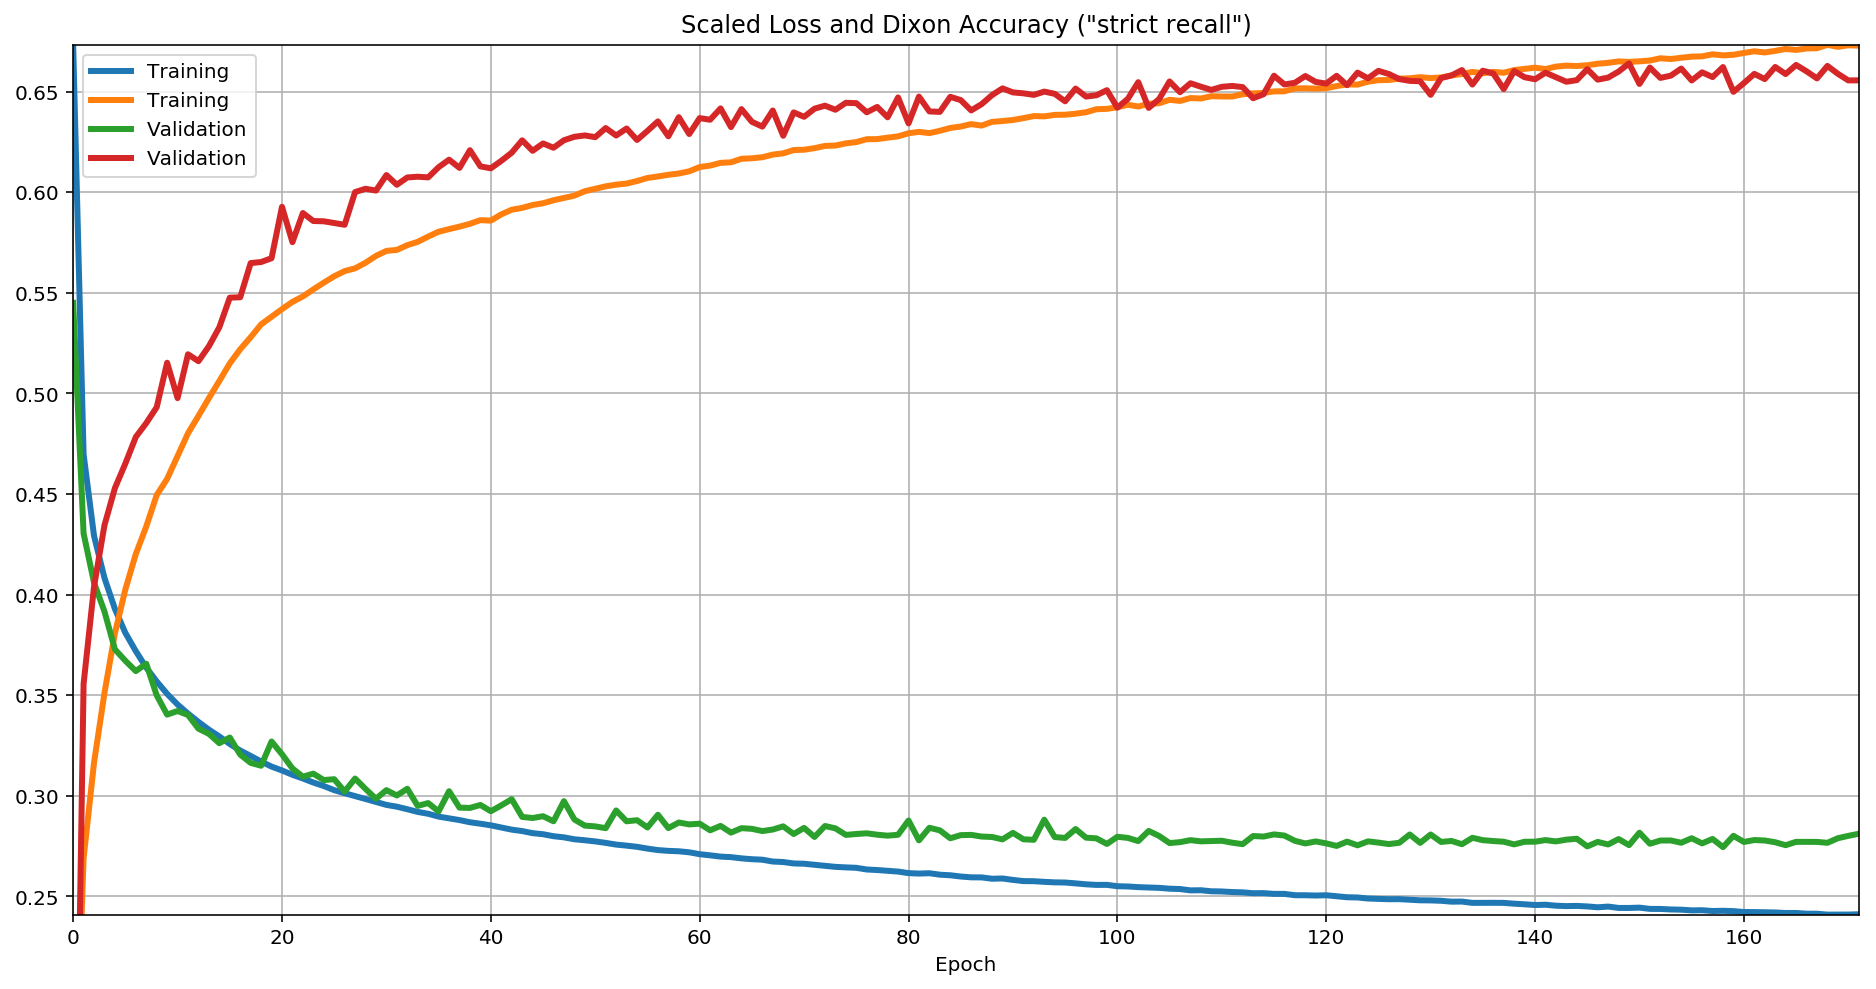

In [49]:
plt.figure(figsize=(16, 8))

maxDixon  = max(hist['Dixon'] + hist['val_Dixon'])
lossScale = max(hist['loss']  + hist['val_loss']) / maxDixon

plt.plot(range(len(hist[     'loss'])), hist[     'loss'] / lossScale, linewidth=3, label='Training')
plt.plot(range(len(hist[    'Dixon'])), hist[    'Dixon'],             linewidth=3, label='Training')
plt.plot(range(len(hist[ 'val_loss'])), hist[ 'val_loss'] / lossScale, linewidth=3, label='Validation')
plt.plot(range(len(hist['val_Dixon'])), hist['val_Dixon'],             linewidth=3, label='Validation')
plt.legend()

plt.title('Scaled Loss and Dixon Accuracy ("stricter than F1-score")')
plt.xlabel('Epoch')
plt.xlim(0,  len(hist['loss']) - 1)
plt.ylim(min(hist['loss'] + hist['val_loss']) / lossScale, maxDixon)
plt.grid()

In [50]:
yProb = model.predict(cqtsTest, evalBatchSize, 1)
assert 0 <= yProb.min() < 1e-6 and 1 - 1e-6 < yProb.max() <= 1
numNotesTrue, numNotesPred = notesTest.sum(1).mean(), yProb.mean() * 88
print('Actual and predicted average number of notes: {:.1f} {:.1f}'.format(numNotesTrue, numNotesPred))
print('Predicts',                'more' if numNotesPred > numNotesTrue else 'less',
      'notes than actual', '(sensitive' if numNotesPred > numNotesTrue else '(specific', 'classifier)')
assert abs(numNotesTrue - numNotesPred) < .5
'Ok.'

128200/128200 [==============================] - 42s 331us/step
Actual and predicted average number of notes: 1.8 2.2
Predicts more notes than actual (sensitive classifier)


'Ok.'

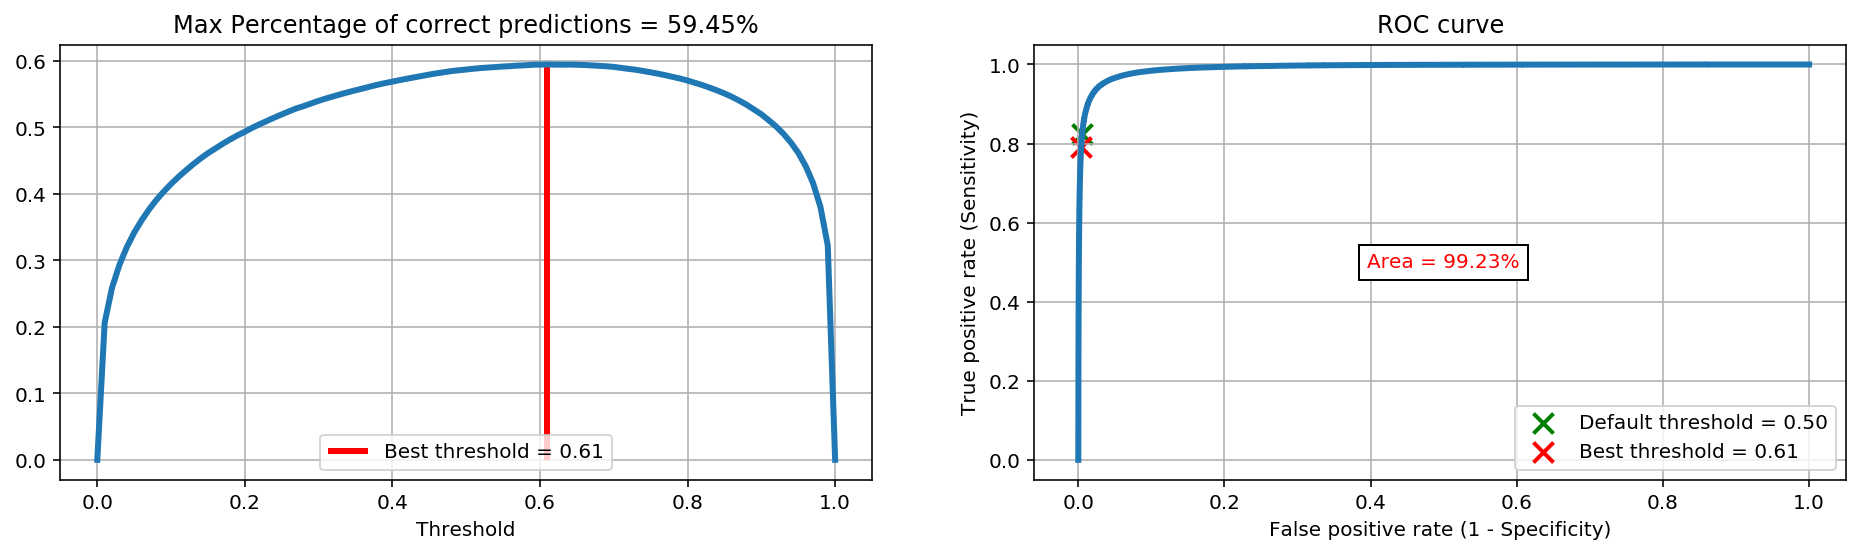

In [51]:
FrameAccuracy = lambda y: (notesTest == y).all(1).mean()

precision = 100
th = [i / precision for i in range(precision + 1)]
acc = [FrameAccuracy(binarize(yProb, t)) for t in th]

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)

plt.plot(th, acc, linewidth=3)
plt.title('Max Percentage of correct predictions = {:.2%}'.format(max(acc)))
plt.xlabel('Threshold')

thBest = acc.index(max(acc)) / precision
plt.vlines(thBest, 0, max(acc), 'r', label='Best threshold = ' + str(thBest), linewidth=3)

plt.legend()
plt.grid()


plt.subplot(1, 2, 2)

fpr, tpr, ths = roc_curve(notesTest.ravel(), yProb.ravel()) # micro-average ROC curve
plt.plot(fpr, tpr, linewidth = 3)

plt.title('ROC curve')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True positive rate (Sensitivity)')

plt.scatter(fpr[ths > .5][-1], tpr[ths > .5][-1], s=100, c='g', marker='x',
            linewidth=2, label='Default threshold = 0.50')
plt.scatter(fpr[ths > thBest][-1], tpr[ths > thBest][-1], s=100, c='r', marker='x',
            linewidth=2, label='Best threshold = ' + str(thBest))

plt.legend()
plt.grid()
plt.text(.5, .5, 'Area = {:.2%}'.format(auc(fpr, tpr)), horizontalalignment='center', verticalalignment='center',
         bbox={'facecolor': 'w', 'alpha': 1}, color='r'); # micro-average area under the ROC curve

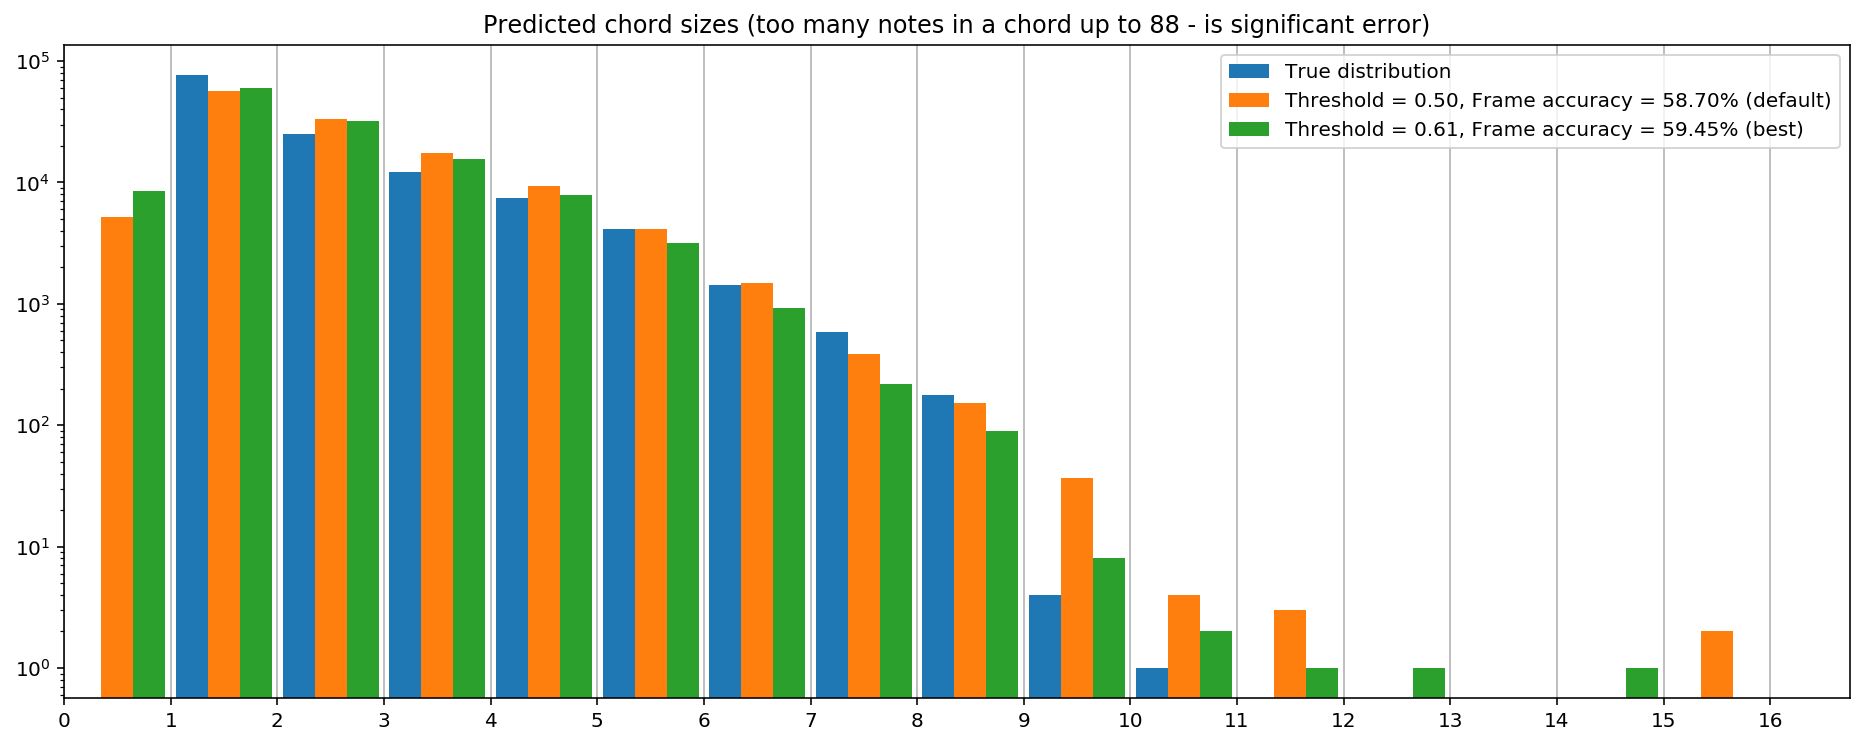

In [52]:
yPred, yPresize = binarize(yProb, .5).astype(int), binarize(yProb, thBest).astype(int)
counts = [notesTest.sum(1), yPred.sum(1), yPresize.sum(1)]
maxCount = np.max(counts)

plt.figure(figsize=(16, 6))
plt.hist(counts, maxCount, rwidth=.9, log=True, label=['True distribution',
    'Threshold = 0.50, Frame accuracy = {:.2%} (default)'.format(        FrameAccuracy(yPred)),
      'Threshold = {}, Frame accuracy = {:.2%} (best)'   .format(thBest, FrameAccuracy(yPresize))])

plt.title('Predicted chord sizes (too many notes in a chord up to 88 - is significant error)')
plt.xlim(0)
plt.xticks(range(maxCount + 1))
plt.grid(axis='x')
plt.legend();

In [5]:
finalHist = None
if exists(modelFolder + '/Final History.npy'): finalHist = np.load(modelFolder + '/Final History.npy')[0]
else:
    preHist = np.load(modelFolder + '/Training History.npy')[0]
    finalHist = {'loss': preHist['loss'][-1:], 'Dixon': preHist['Dixon'][-1:]}

print('Loading pre-trained final model...')
finalModel = load_model(modelFolder + '/Final Model.hp5', {'Dixon': Dixon})
print('Spent', len(finalHist['loss']) - 1, 'epochs after validating.')

Loading pre-trained final model...
Spent 306 epochs after validating.


In [6]:
dixon = 0
while dixon < finalHist['Dixon'][-1]:
    dixon, newHist = finalHist['Dixon'][-1], finalModel.fit(cqts, notes, batchSize, 10, callbacks=[
        EarlyStopping('loss', patience=3, verbose=1)]).history
    finalHist = {key: finalHist[key] + val for key, val in newHist.items()}
    np.save(      '{}/Final History {:.2f} 65 59'.    format(modelFolder, finalHist['Dixon'][-1] * 100), [finalHist])
    finalModel.save('{}/Final Model {:.2f} 65 59.hp5'.format(modelFolder, finalHist['Dixon'][-1] * 100))

Epoch 1/10
512798/512798 [==============================] - 656s 1ms/step - loss: 2.0538 - Dixon: 0.7073
Epoch 2/10
512798/512798 [==============================] - 642s 1ms/step - loss: 2.0512 - Dixon: 0.7076
Epoch 3/10
512798/512798 [==============================] - 631s 1ms/step - loss: 2.0518 - Dixon: 0.7077
Epoch 4/10
512798/512798 [==============================] - 631s 1ms/step - loss: 2.0504 - Dixon: 0.7085
Epoch 5/10
512798/512798 [==============================] - 634s 1ms/step - loss: 2.0520 - Dixon: 0.7081
Epoch 6/10
512798/512798 [==============================] - 633s 1ms/step - loss: 2.0510 - Dixon: 0.7081
Epoch 7/10
512798/512798 [==============================] - 634s 1ms/step - loss: 2.0518 - Dixon: 0.7080
Epoch 00007: early stopping
Epoch 1/10
512798/512798 [==============================] - 633s 1ms/step - loss: 2.0499 - Dixon: 0.7085
Epoch 2/10
512798/512798 [==============================] - 634s 1ms/step - loss: 2.0502 - Dixon: 0.7085
Epoch 3/10
512798/512798 [=

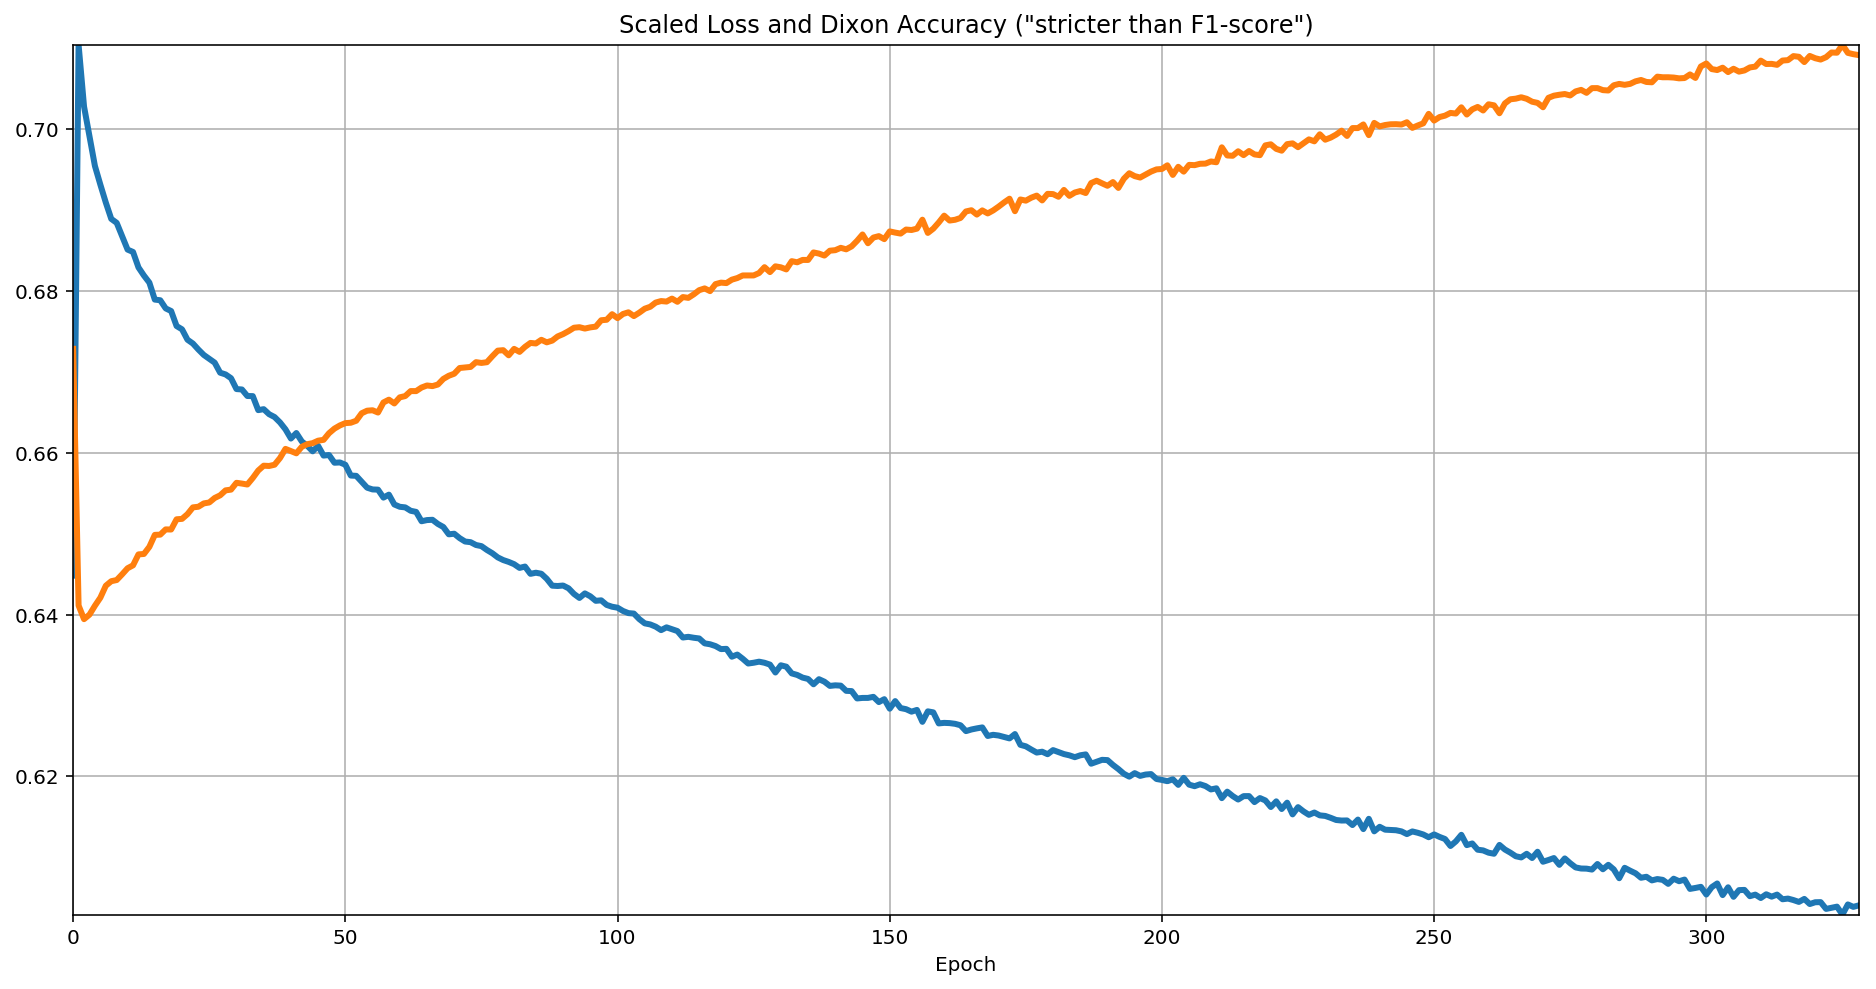

In [7]:
plt.figure(figsize=(16, 8))

maxDixon  = max(finalHist['Dixon'])
lossScale = max(finalHist['loss']) / maxDixon

plt.plot(range(len(finalHist['loss'])),  finalHist['loss'] / lossScale, linewidth=3)
plt.plot(range(len(finalHist['Dixon'])), finalHist['Dixon'],            linewidth=3)

plt.title('Scaled Loss and Dixon Accuracy ("stricter than F1-score")')
plt.xlabel('Epoch')
plt.xlim(0, len(finalHist['loss']) - 1)
plt.ylim(   min(finalHist['loss']) / lossScale, maxDixon)
plt.grid()

#### https://github.com/Dobiasd/frugally-deep/tree/master/keras_export

In [8]:
finalModel.save('Model Train71 Val65 Frame59.h5', include_optimizer=False)
%run convert_model.py "Model Train71 Val65 Frame59.h5" "KerasModel Train71 Val65 Frame59.json"

loading Model Train71 Val65 Frame59.h5


C:\Anaconda3_64\lib\site-packages\keras\models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Forward pass took 2.338788 s.
Forward pass took 0.046857 s.
Forward pass took 0.015609 s.
Starting performance measurements.
Forward pass took 0.01561 s.
Forward pass took 0.025875 s.
Forward pass took 0.006153 s.
Forward pass took 0.01562 s.
Forward pass took 0.031251 s.
Forward pass took 0.0189018 s on average.
writing KerasModel Train71 Val65 Frame59.json
